In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os 
import osmnx as ox
import networkx as nx
import sys
from pathlib import Path

# allow imports from src/
PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT))

from src.plotting.styles import get_style, latex_escape
# import dataloader function
from src.data.dataload import load_csv_folder_to_dataframe

### Distance and Correlation

This Jupyter Notebook analyzes the spatial distances and correlations of bicycle counters in German cities. It allows you to check correlations between different counting sites and visualize the results.

The notebook is flexible: the city can be changed in Block 10 to run the analysis for any city with eco-counters.

1. Euclidean Distance: Compute straight-line distances between all counters in a city.
2. Bike Distance: Calculate realistic cycling distances along streets and bike paths.
3. Correlation: Check if counting sites show similar cycling activity patterns.
4. Visualization: Display distances and correlations for easy interpretation.

##### Supported Cities and Number of Eco-Counters

- "Landeshauptstadt Stuttgart": 15/15 counter (FERTIG) ~~9000m
- `df_domain = df_all[df_all["domain_name"] == "Landeshauptstadt Stuttgart"]`

- "Stadt Ludwigsburg": 15/15 counter (FERTIG) ~~7000m
- `df_domain = df_all[df_all["domain_name"] == "Stadt Ludwigsburg"]`

"Stadt Heidelberg": 13/15 counter (FERTIG) ~~7000m
- `df_domain = df_all[df_all["domain_name"] == "Stadt Heidelberg"]`
- `df_domain = df_domain[df_domain["counter_site"] != "Ernst-Walz-Brücke West - alt"]`
remove this station as there is no overlap with the others

"Stadt Mannheim": 11/14 counter (FERTIG) ~~7000m
- `df_domain = df_all[df_all["domain_name"] == "Stadt Mannheim"]`

"Stadt Freiburg": 10/11 counter (FERTIG) ~~7000m
- `df_domain = df_all[df_all["domain_name"] == "Stadt Freiburg"]`

"Stadt Reutlingen": 8/8 counter (FERTIG) ~~7000m
- `df_domain = df_all[df_all["domain_name"] == "Stadt Reutlingen"]`

"Ravensburg Tws Gmbh & Co. Kg": 7/7 counter (FERTIG) ~~7000m
- `df_domain = df_all[df_all["domain_name"] == "Ravensburg Tws Gmbh & Co. Kg"]`

"Stadt Konstanz": 6/6 counter (FERTIG) ~~7000m
- `df_domain = df_all[df_all["domain_name"] == "Stadt Konstanz"]`

"Stadt Tübingen": 5/5 counter (FERTIG) ~~7000m
- `df_domain = df_all[df_all["domain_name"] == "Stadt Tübingen"]`

In [2]:
DATA_DIR = PROJECT_ROOT / "data/raw"
PLOTS_DIR = PROJECT_ROOT / "outputs/plots"
distcorr_plot_dir = PLOTS_DIR / "distcorr"
distcorr_plot_dir.mkdir(parents=True, exist_ok=True)
TABLES_DIR = PROJECT_ROOT / "outputs/tables"
TABLES_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR = PROJECT_ROOT / "data/processed"

# if df_all.csv exists load it as dataframe (faster), else load from raw data
df_all_path = PROCESSED_DIR / "df_all.csv"
if df_all_path.exists():
    print("Loading preprocessed dataframe from", df_all_path)
    df_all = pd.read_csv(df_all_path)
else:
    ## get data and preprocess
    df_all = load_csv_folder_to_dataframe(DATA_DIR)

##  timestamps to datetime
df_all['iso_timestamp'] = pd.to_datetime(df_all['iso_timestamp'], utc=True, format='mixed')

# change columns to numerics
numeric_cols = [
    "channels_in", "channels_out", "channels_unknown", "channels_all", 
    "site_temperature", "site_rain_accumulation", "site_snow_accumulation"]

df_all[numeric_cols] = df_all[numeric_cols].apply(pd.to_numeric, errors='coerce')

df_all["count"] = df_all[["channels_out", "channels_in", "channels_unknown"]].fillna(0).sum(axis=1)

# subset of dataframe just for one town 
df_domain = df_all[df_all["domain_name"] == "Stadt Ludwigsburg"] ### change domain name here for other towns

# remove outliers
max_count = 1000
df_domain = df_domain[df_domain["count"] <= max_count]

title_domain = df_domain["domain_name"].iloc[0]
print(title_domain)
df_domain_grouped = df_domain.groupby("counter_site")

# get coordinates for every counter site
domain_coords = {
    name: (
        df_domain_grouped.get_group(name)["latitude"].iloc[0],
        df_domain_grouped.get_group(name)["longitude"].iloc[0]
    )
    for name in df_domain_grouped.groups.keys()
}

domain_slug = title_domain.replace(" ", "_").lower()
distcorr_plot_dir = distcorr_plot_dir / domain_slug
distcorr_plot_dir.mkdir(parents=True, exist_ok=True)

Loading preprocessed dataframe from C:\Users\Clee\Desktop\Uni\M.Sc. Kogni\Data Literacy\fahrradzaehler\data\processed\df_all.csv
Stadt Ludwigsburg


#### 1. Bike Distance

In this step, we compute the realistic cycling distance between counter sites using the **Osmnx** package, which builds a graph of streets and bike paths.  

1.1. Create graph:
   - We define a **center node** as the mean latitude and longitude of all counter sites.  
   - The **network type** is set to `"bike"` to include only bike-accessible streets and paths.  
   - The **radius** is chosen as the half of the maximum Euclidean distance (+100m) between all counter sites to ensure all sites are included in the graph.  

1.2. Calculate distances: 
   - We use `nx.shortest_path_length()` from NetworkX to compute the shortest path (bike distance) between all pairs of counters on the graph.  
   - The results are stored in a **distance matrix**, similar in format to the Euclidean distance matrix.  

**Output:**  
A symmetric **bike distance matrix** where each element $(i,j)$ represents the shortest cycling distance between counter $i$ and counter $j$.

In [3]:
from haversine import haversine, Unit
# 1.1 create graph from OSM streetmaps
# compute mean of lats and lons for center point
sites1 = list(domain_coords.keys())
lats = [coord[0] for coord in domain_coords.values()]
cp_lat = np.mean(lats)
lons = [coord[1] for coord in domain_coords.values()]
cp_lon = np.mean(lons)
# set mean as center point 
center_point = (cp_lat, cp_lon)  

# max euclidean distance between counter sites (for setting radius)
max_euc_dist = 0
for i in domain_coords:
    for j in domain_coords:
        lat1, lon1 = domain_coords[i]
        lat2, lon2 = domain_coords[j]
        d = haversine((lat1, lon1), (lat2, lon2), unit=Unit.METERS)
        if d > max_euc_dist:
            max_euc_dist = d
print("Max euclidean distance between counter sites:", max_euc_dist, "m")

# access streetmaps graph with bike lanes, with mean cp and x km radius (adjust if needed)
G = ox.graph_from_point(center_point, dist=(max_euc_dist / 2) + 1200, network_type='bike')
largest_scc = max(nx.strongly_connected_components(G), key=len)
G_scc = G.subgraph(largest_scc).copy()

# nodes in our graph are our counter sites 
snapped_nodes = {}
counter_to_node_dist = {}
for name, (lat, lon) in domain_coords.items():
    node, dist = ox.distance.nearest_nodes(G, X=lon, Y=lat, return_dist=True)
    snapped_nodes[name] = node
    counter_to_node_dist[name] = dist

snapped_nodes_scc = {
    name: node
    for name, node in snapped_nodes.items()
    if node in G_scc.nodes
}

dropped_stations = set(snapped_nodes) - set(snapped_nodes_scc)
print("Dropped stations:", dropped_stations)
print("Remaining stations:", len(snapped_nodes_scc), "out of", len(snapped_nodes))

counter_to_node_dist = {
    name: dist
    for name, dist in counter_to_node_dist.items()
    if name in snapped_nodes_scc
}

G = G_scc
snapped_nodes = snapped_nodes_scc


# 1.2 compute shortest path distances between all counter sites
sites1 = list(snapped_nodes.keys())
distances1 = {}
for i in snapped_nodes:
    for j in snapped_nodes:
        if (j, i) in distances1:
            distances1[(i, j)] = distances1[(j, i)]
            continue
        if i == j:
            distances1[(i, j)] = 0
            continue
        d = nx.shortest_path_length(G, snapped_nodes[i], snapped_nodes[j], weight='length')
        distances1[(i, j)] = d
        #print(f"distance between {i} and {j}: {d:.1f} m")


# 1.3 create distance matrix (for bike dist)
dist_matrix = pd.DataFrame(index=sites1, columns=sites1)
for (site1, site2), dist in distances1.items():
    dist_matrix.loc[site1, site2] = dist
    dist_matrix.loc[site2, site1] = dist

# fill diagonal with 0
dist_matrix.fillna(0, inplace=True)


Max euclidean distance between counter sites: 5865.480204795732 m
Dropped stations: set()
Remaining stations: 15 out of 15


In [4]:
snapping_df = pd.DataFrame.from_dict(
    counter_to_node_dist,
    orient="index",
    columns=["snap_distance_m"]
).sort_values("snap_distance_m", ascending=False)

snapping_df

print("Stations >50m snapped:")
print(snapping_df[snapping_df["snap_distance_m"] > 50])

Stations >50m snapped:
          snap_distance_m
Fuchshof        69.450867


#### 2. Euclidean Distance

In this step, we compute the Euclidean (straight-line) distance between all counter sites based on their geographic coordinates.

We first convert the latitude and longitude from degrees to a Cartesian coordinate system using the following formula:

\begin{aligned}
x &= R \cdot \cos(\varphi_0) \cdot \mathrm{rad}(\lambda), \\
y &= R \cdot \mathrm{rad}(\varphi),
\end{aligned}
where
$\mathrm{rad}(\alpha) = \alpha \cdot \frac{\pi}{180}$

Variables:
- $\varphi$ : latitude in degrees 
- $\lambda$ : longitude in degrees 
- $\varphi_0$ : reference latitude
- $R = 6{,}371{,}000\,\text{m}$ : earth radius

Once converted to Cartesian coordinates, the Euclidean distance $d_{ij}$ between two counters $i$ and $j$ is computed as:

$d_{ij} = \sqrt{(x_i - x_j)^2 + (y_i - y_j)^2}$

**Output:**  
A symmetric **distance matrix** where each element $(i,j)$ represents the straight-line distance between counter $i$ and counter $j$

In [5]:
# 2.1 reference latitude for the conversion
snapped_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in snapped_nodes.values()]
lat0 = np.mean([lat for lat, lon in snapped_coords])

# 2.2 define function to convert lat/lon to x/y in meters
def latlon_to_xy(coord, lat0=lat0):
    lat, lon = coord
    R = 6371000 # radius of earth in meters
    x = R * np.radians(lon) * np.cos(np.radians(lat0))
    y = R * np.radians(lat)
    return np.array([x, y])

# 2.3 distance matrix
dist_matrix_euclid = pd.DataFrame(index=sites1, columns=sites1, dtype=float)

for a in sites1:
    for b in sites1:
        n1 = (G.nodes[snapped_nodes[a]]['y'], G.nodes[snapped_nodes[a]]['x'])
        n2 = (G.nodes[snapped_nodes[b]]['y'], G.nodes[snapped_nodes[b]]['x'])
        p1 = latlon_to_xy(n1)
        p2 = latlon_to_xy(n2)
        dist_matrix_euclid.loc[a, b] = np.linalg.norm(p1 - p2)

diff_matrix = dist_matrix - dist_matrix_euclid
neg_pairs = np.where(diff_matrix < 0)
print(neg_pairs)

(array([], dtype=int64), array([], dtype=int64))


#### Optional

The next cell block is mainly to plot the routes between two respective counter sites (uncomment the last line of the loop). For Tübingen this is not too much as

$\binom{n}{2} = \frac{n(n-1)}{2}$

so for 5 stations 

$\binom{5}{2} = \frac{5(5-1)}{2}=10$

but for cities like Ludwigsburg or Stuttgart we have 15 counters, so proceed with caution.

In [6]:
# compute all the routes as well and store them in a dict
# you can plot it too! (uncomment last line)
routes = {}

keys = list(snapped_nodes.keys())

for i in keys:
    for j in keys:
        if (j, i) in routes:
            routes[(i, j)] = routes[(j, i)]
            continue
        if i == j:
            routes[(i, j)] = [snapped_nodes[i]]
            continue
        r = nx.shortest_path(G, snapped_nodes[i], snapped_nodes[j], weight='length')
        routes[(i, j)] = r
        # ox.plot_graph_route(G, r)


#### 3. Correlation

This section analyzes correlations between bicycle counts at different counter sites.

##### 3.1 Correlation Matrix (All Available Data)

We compute the Pearson correlation matrix using all available overlapping data points.
Missing values are ignored pairwise.

The resulting correlation matrix is visualized as a heatmap to highlight similarities
and differences between counter sites.

##### 3.2 Correlation Matrix (Fully Aligned Data)

To ensure that all correlations are based on the same timestamps, we remove all rows
containing missing values.

The correlation matrix is recomputed using only fully aligned time series.
This provides a stricter and more conservative correlation estimate.

##### 3.3 Difference Between Correlation Matrices

Finally, we compute the difference between the aligned and unaligned correlation matrices.

This highlights how much the correlation values change when missing data is excluded
entirely, and helps identify correlations that are sensitive to data availability.

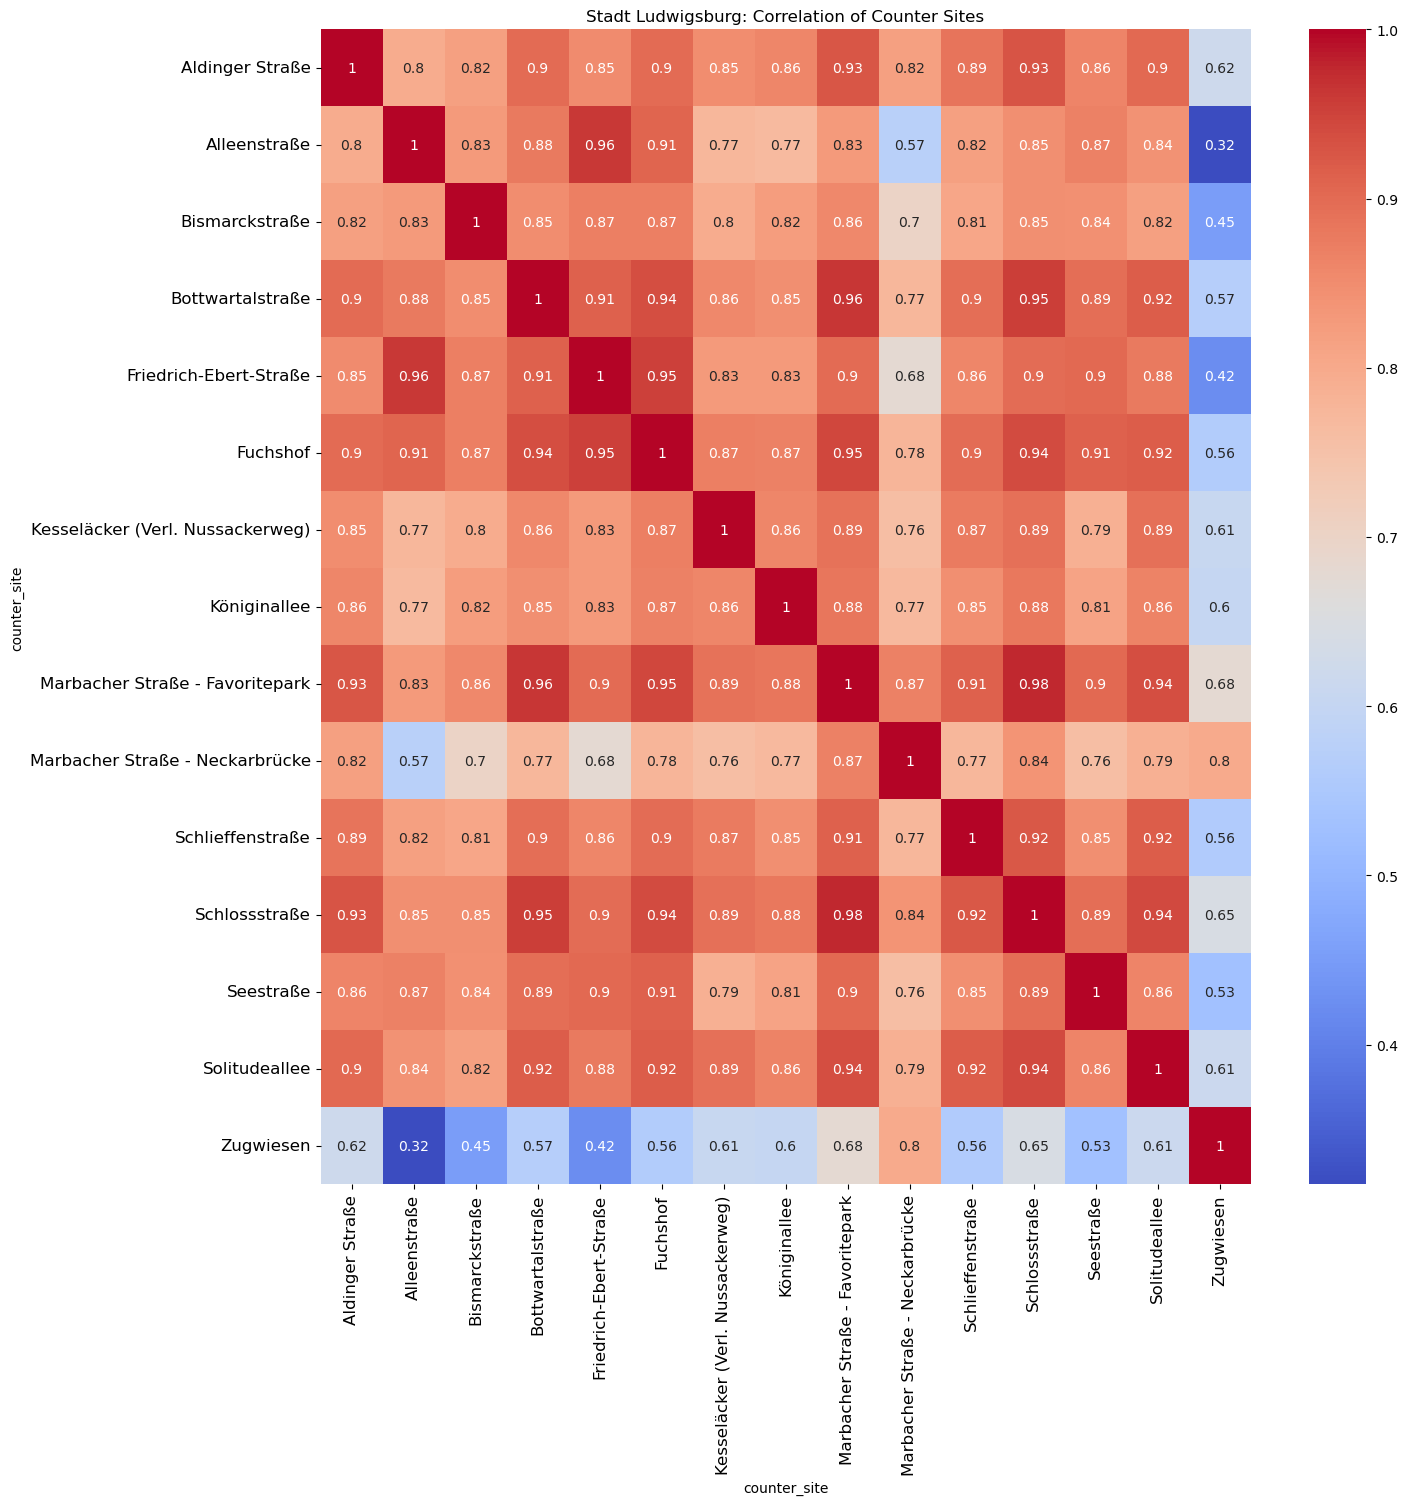

In [7]:
# 3.1 pivot table for correlation matrix
df_domain_pivot = df_domain.pivot_table(
    index = 'iso_timestamp',
    columns = 'counter_site',
    values = 'count',
    aggfunc='sum'
)

# we want to see how many timestamps have data for both sites
mask = df_domain_pivot.notna().astype(int)
overlap = mask.T.dot(mask)
# 3.2 compute correlation matrix and plot heatmap
corr_matrix = df_domain_pivot.corr()

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title(f"{title_domain}: Correlation of Counter Sites")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Total timestamps: 70852
Aligned timestamps: 39386


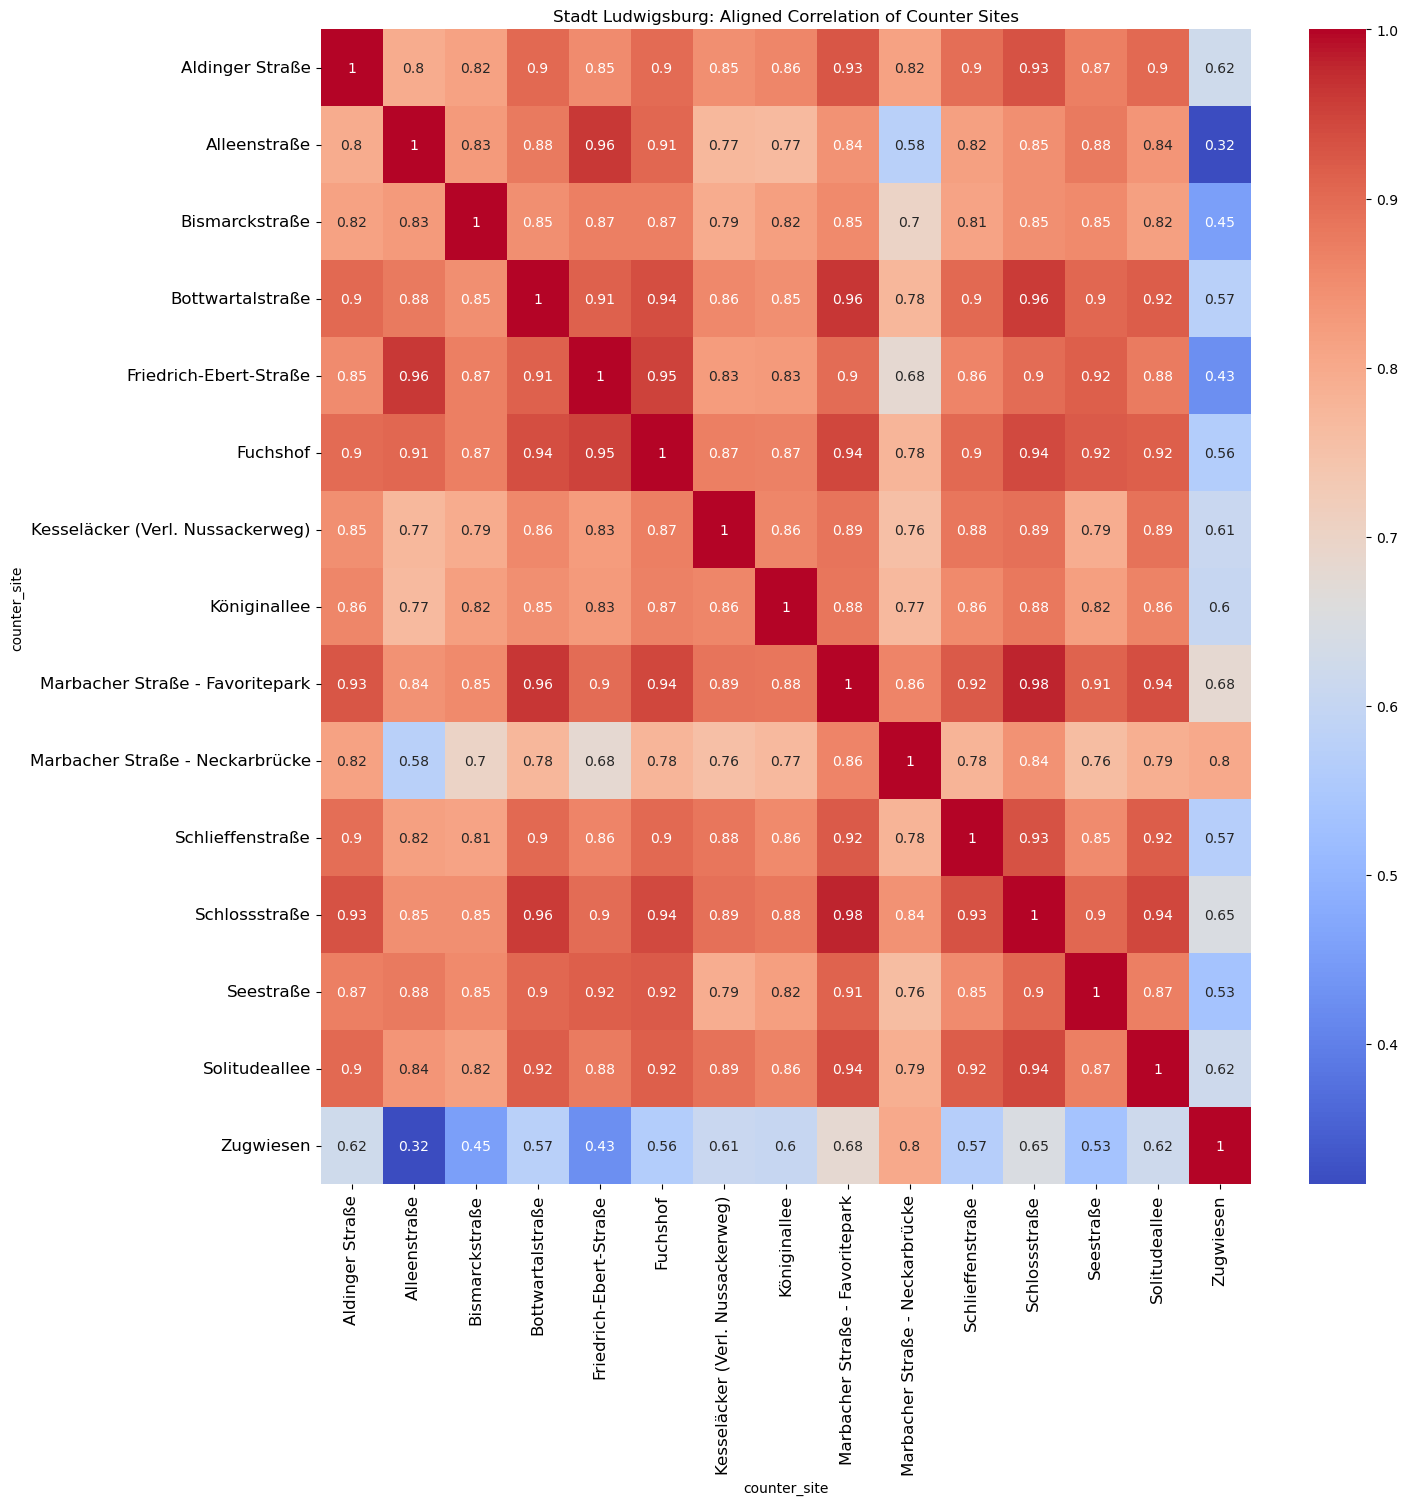

In [8]:
# 3.3 correlation matrix for just times where all sites have data
aligned = df_domain_pivot.dropna()
corr_matrix1 = aligned.corr()
n_total = len(df_domain_pivot)
print("Total timestamps:", n_total)
n_aligned = len(aligned)
print("Aligned timestamps:", n_aligned)

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix1, annot=True, cmap='coolwarm')
plt.title(f"{title_domain}: Aligned Correlation of Counter Sites")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

0.011465508808205849


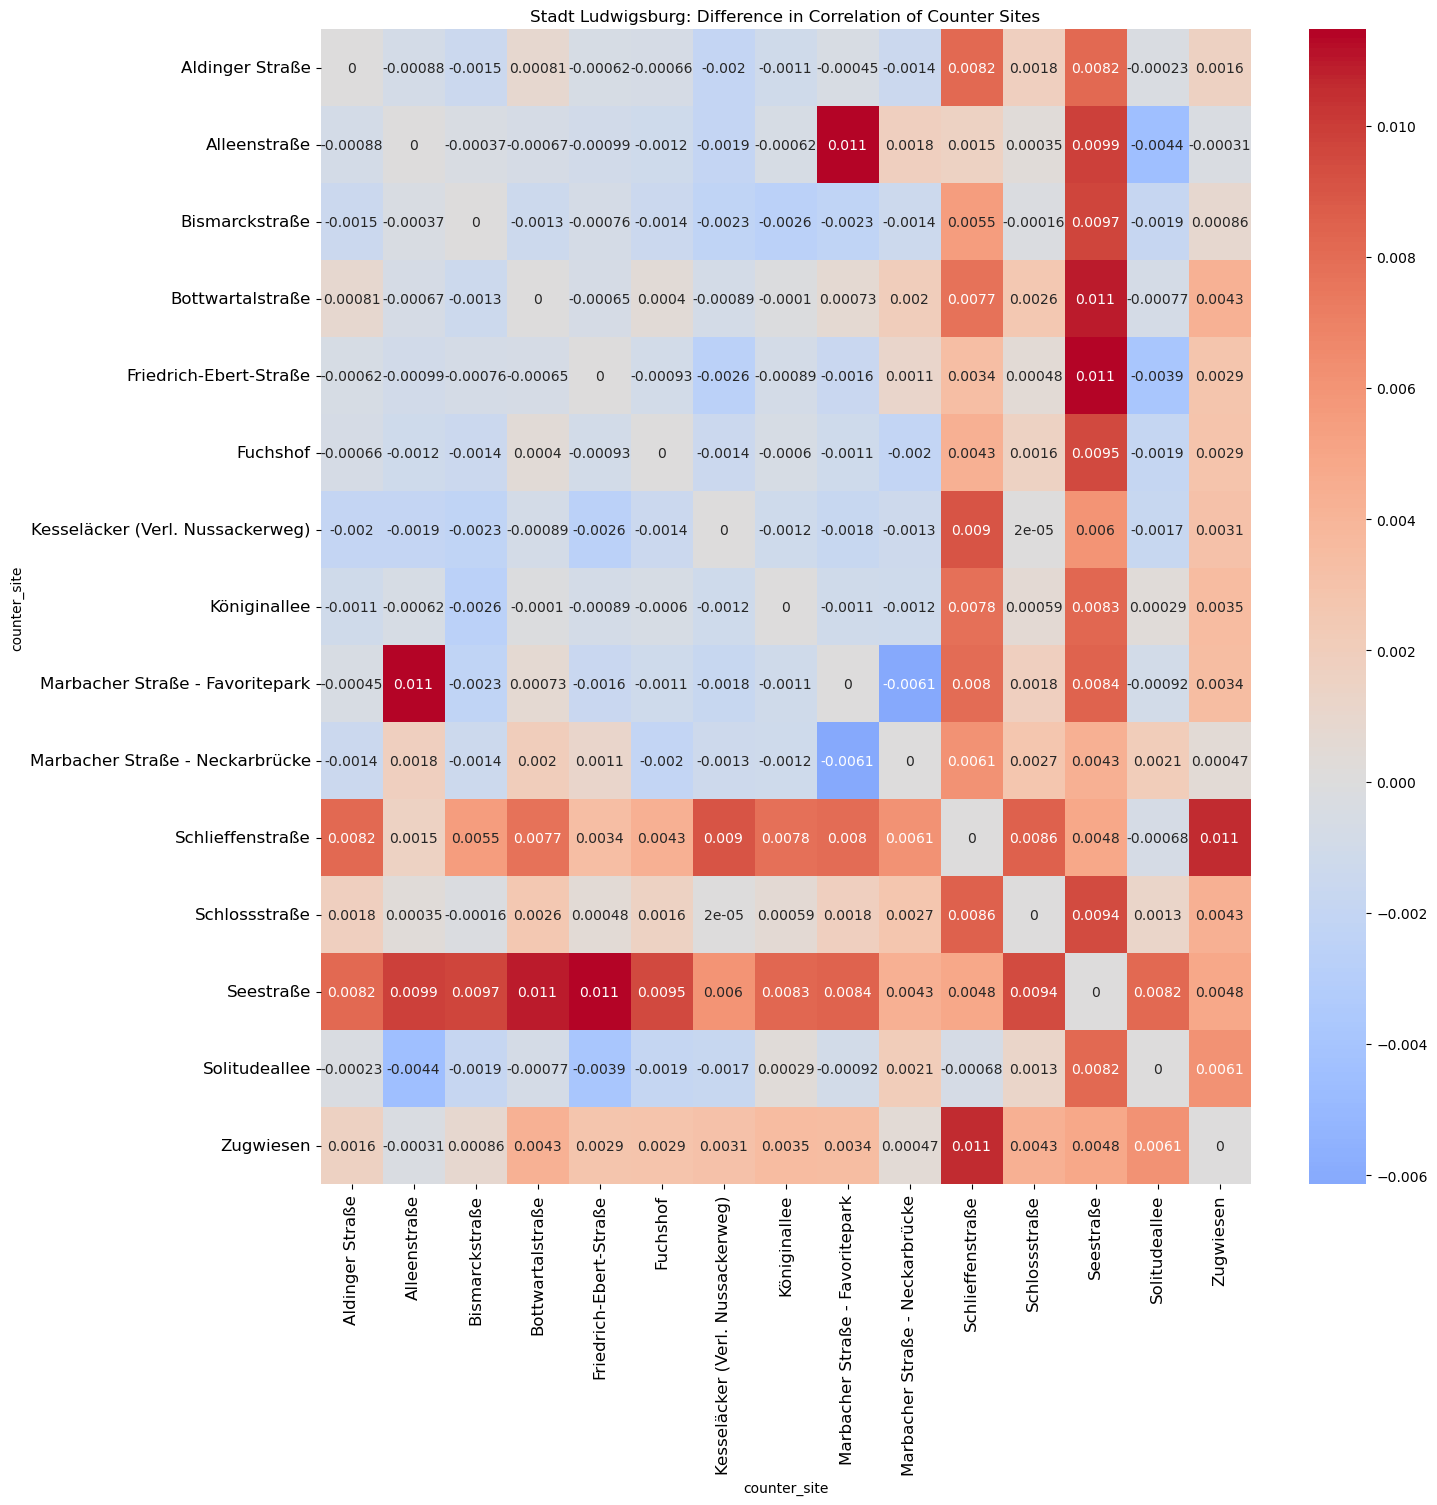

In [9]:
# 3.4 difference between the two correlation matrices
corr_diff = corr_matrix1 - corr_matrix
print(abs(corr_diff).max().max())

plt.figure(figsize=(15, 15))
sns.heatmap(corr_diff, annot=True, cmap='coolwarm', center=0)
plt.title(f"{title_domain}: Difference in Correlation of Counter Sites")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Figure: Difference in Correlations. 

To assess the robustness of correlations across counter sites, we compared the correlation matrix computed using all available time points with the matrix computed only from time points where all sites were simultaneously active.  

The maximum difference observed between corresponding pairwise correlations was 0.12, indicating that the overall correlation structure is largely unaffected by differences in temporal coverage.

## Spearman Correlation Matrices


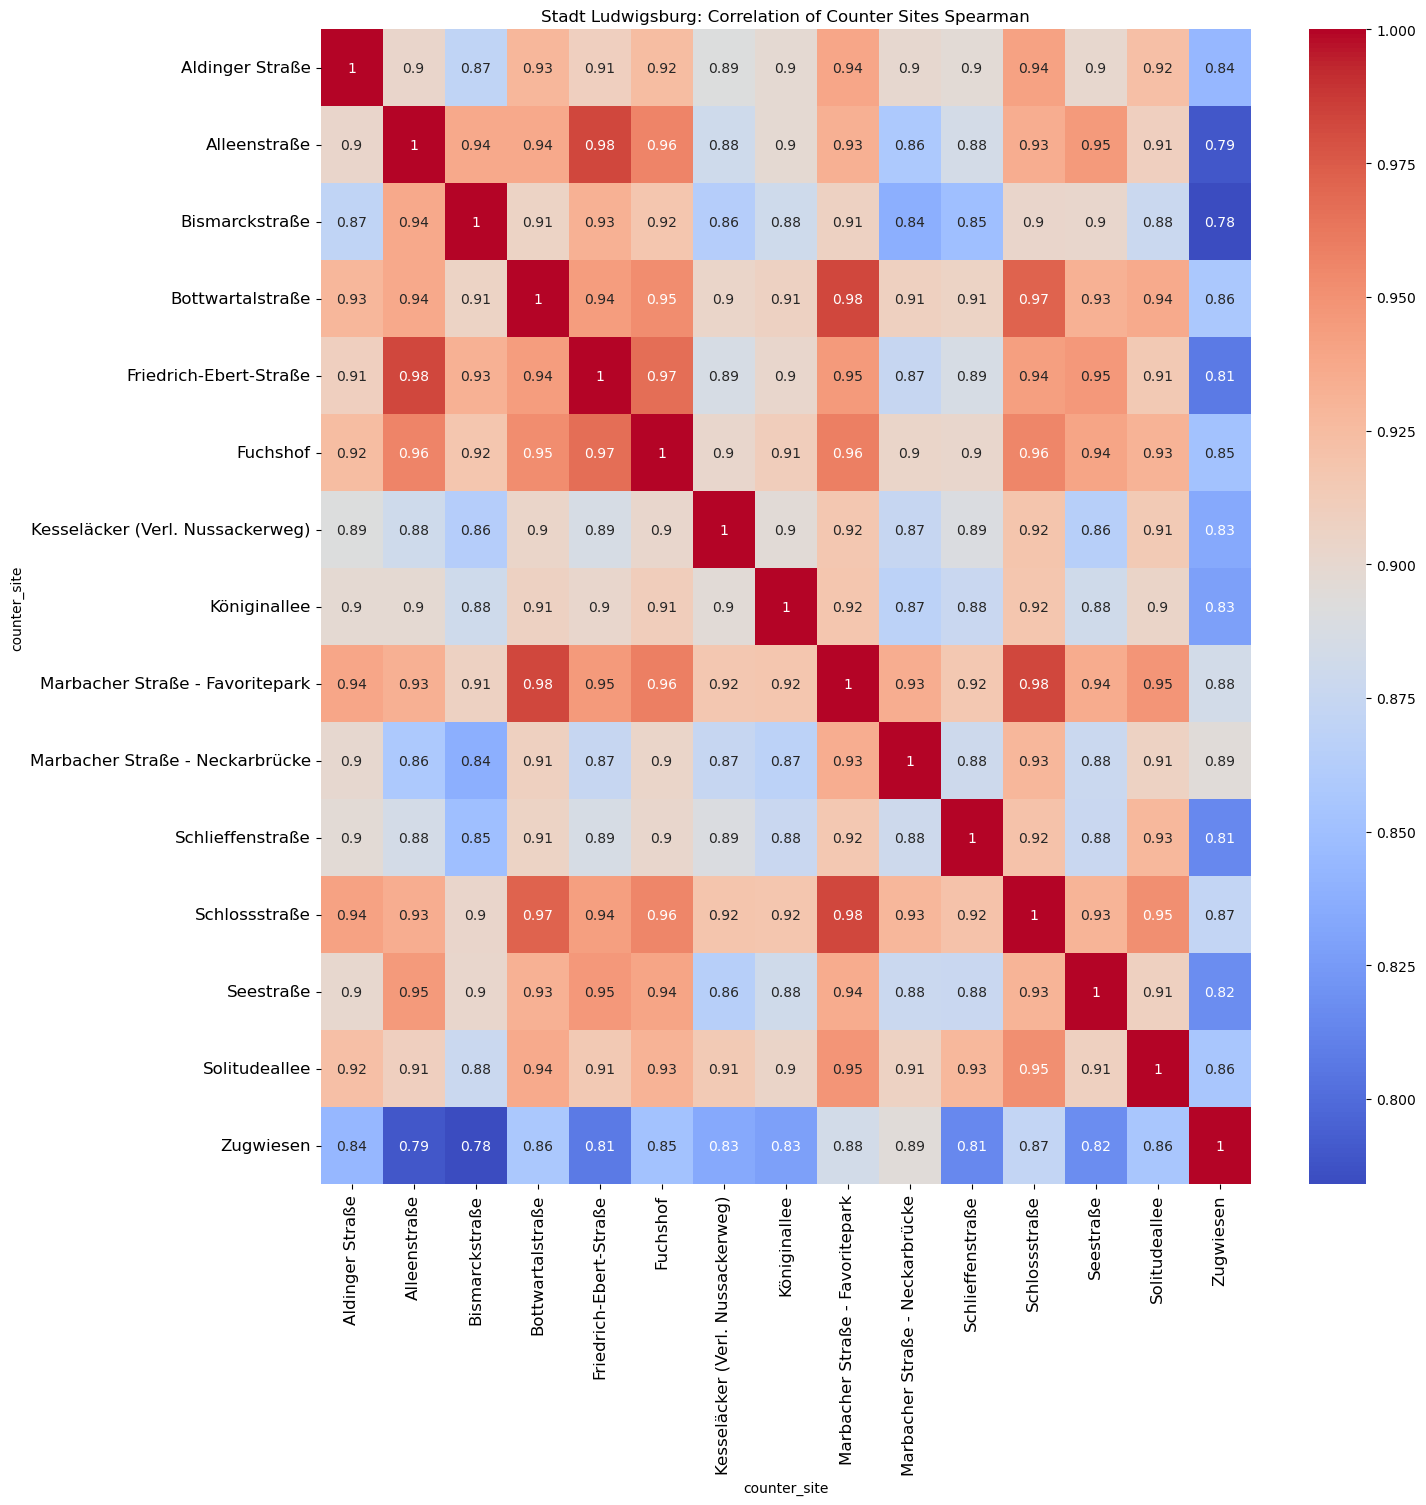

In [10]:
# 3.5 pivot table for correlation matrix spearman
df_domain_pivot_spearman = df_domain.pivot_table(
    index = 'iso_timestamp',
    columns = 'counter_site',
    values = 'count',
    aggfunc='sum'
)

# we want to see how many timestamps have data for both sites
mask_spearman = df_domain_pivot_spearman.notna().astype(int)
overlap_spearman = mask_spearman.T.dot(mask_spearman)
# 3.6 compute correlation matrix and plot heatmap
corr_matrix_spearman = df_domain_pivot_spearman.corr(method='spearman')

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix_spearman, annot=True, cmap='coolwarm')
plt.title(f"{title_domain}: Correlation of Counter Sites Spearman")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Total timestamps: 70852
Aligned timestamps: 39386


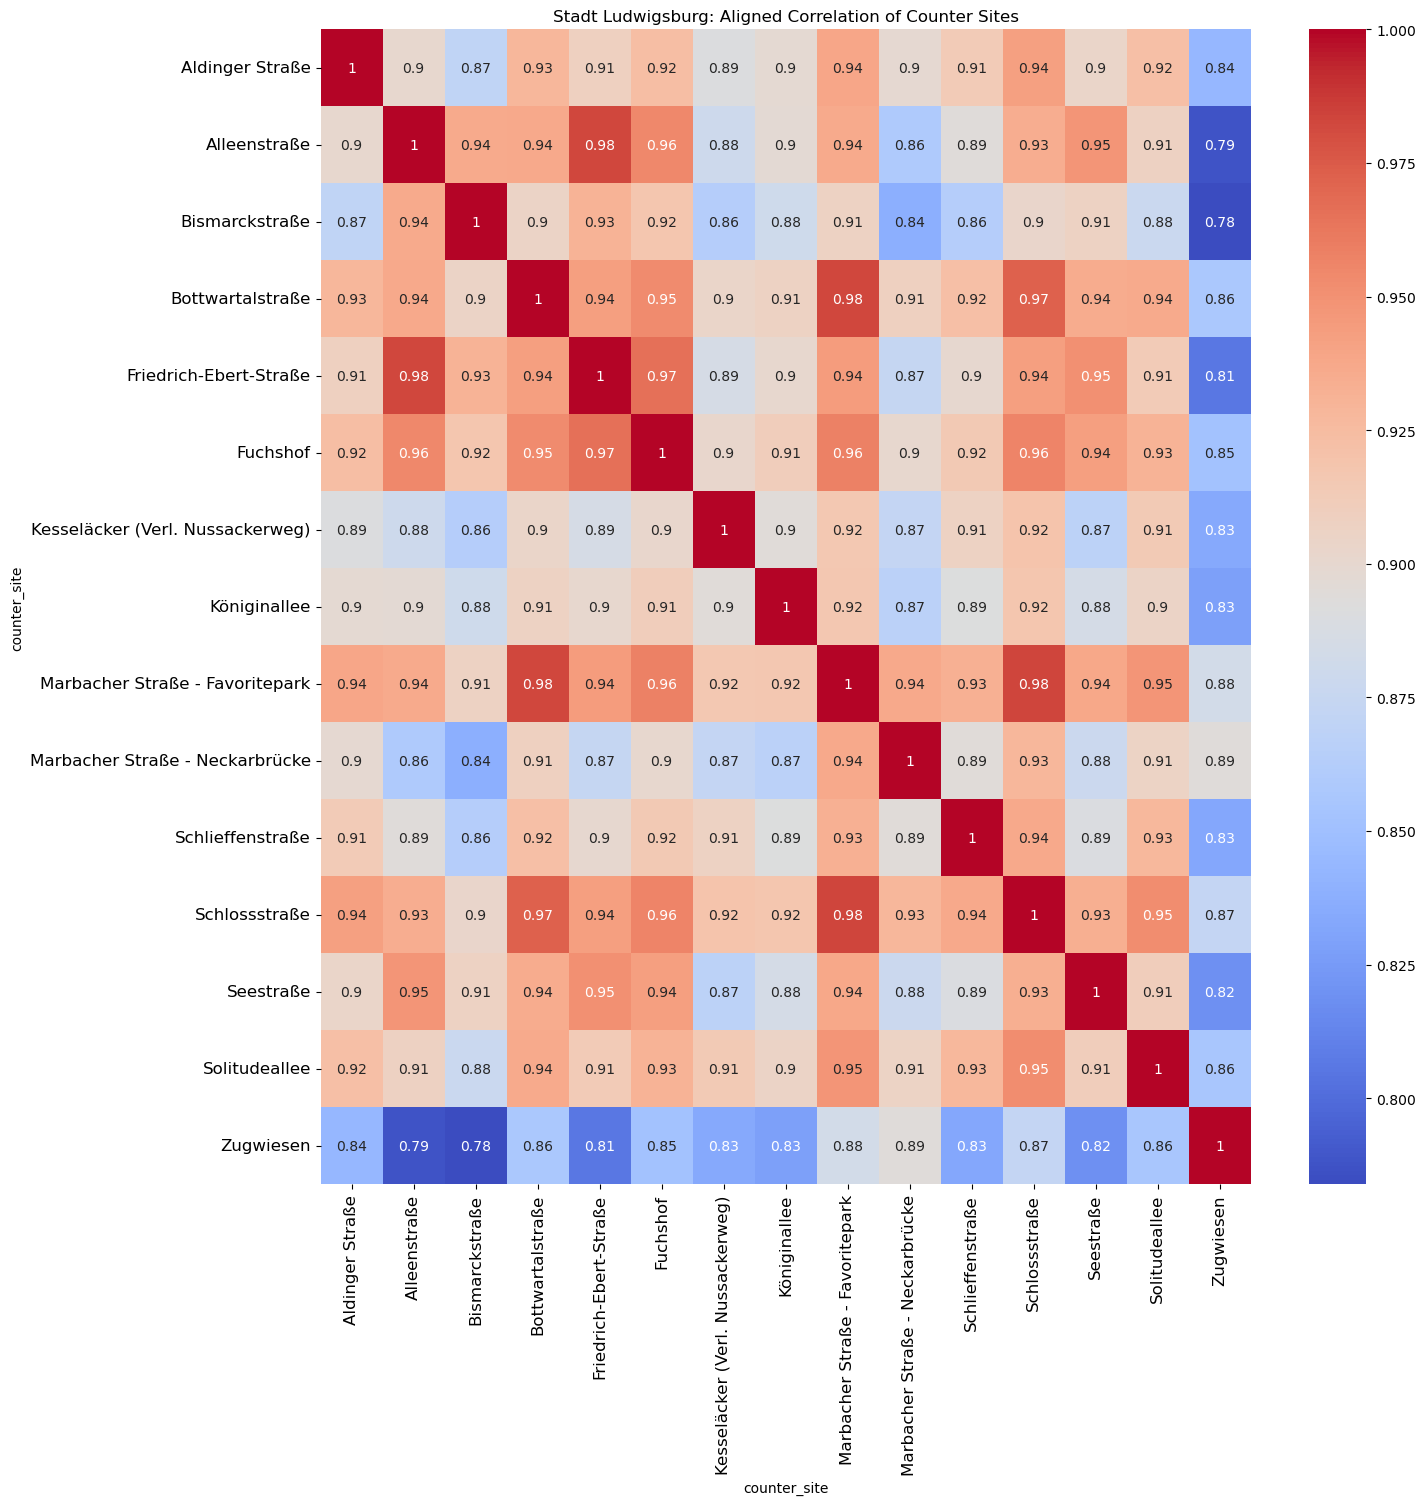

In [11]:
# 3.7 correlation matrix for just times where all sites have data
aligned_spearman = df_domain_pivot_spearman.dropna()
corr_matrix1_spearman = aligned_spearman.corr(method='spearman')
n_total = len(df_domain_pivot_spearman)
print("Total timestamps:", n_total)
n_aligned = len(aligned_spearman)
print("Aligned timestamps:", n_aligned)

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix1_spearman, annot=True, cmap='coolwarm')
plt.title(f"{title_domain}: Aligned Correlation of Counter Sites")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

0.017756816839391232


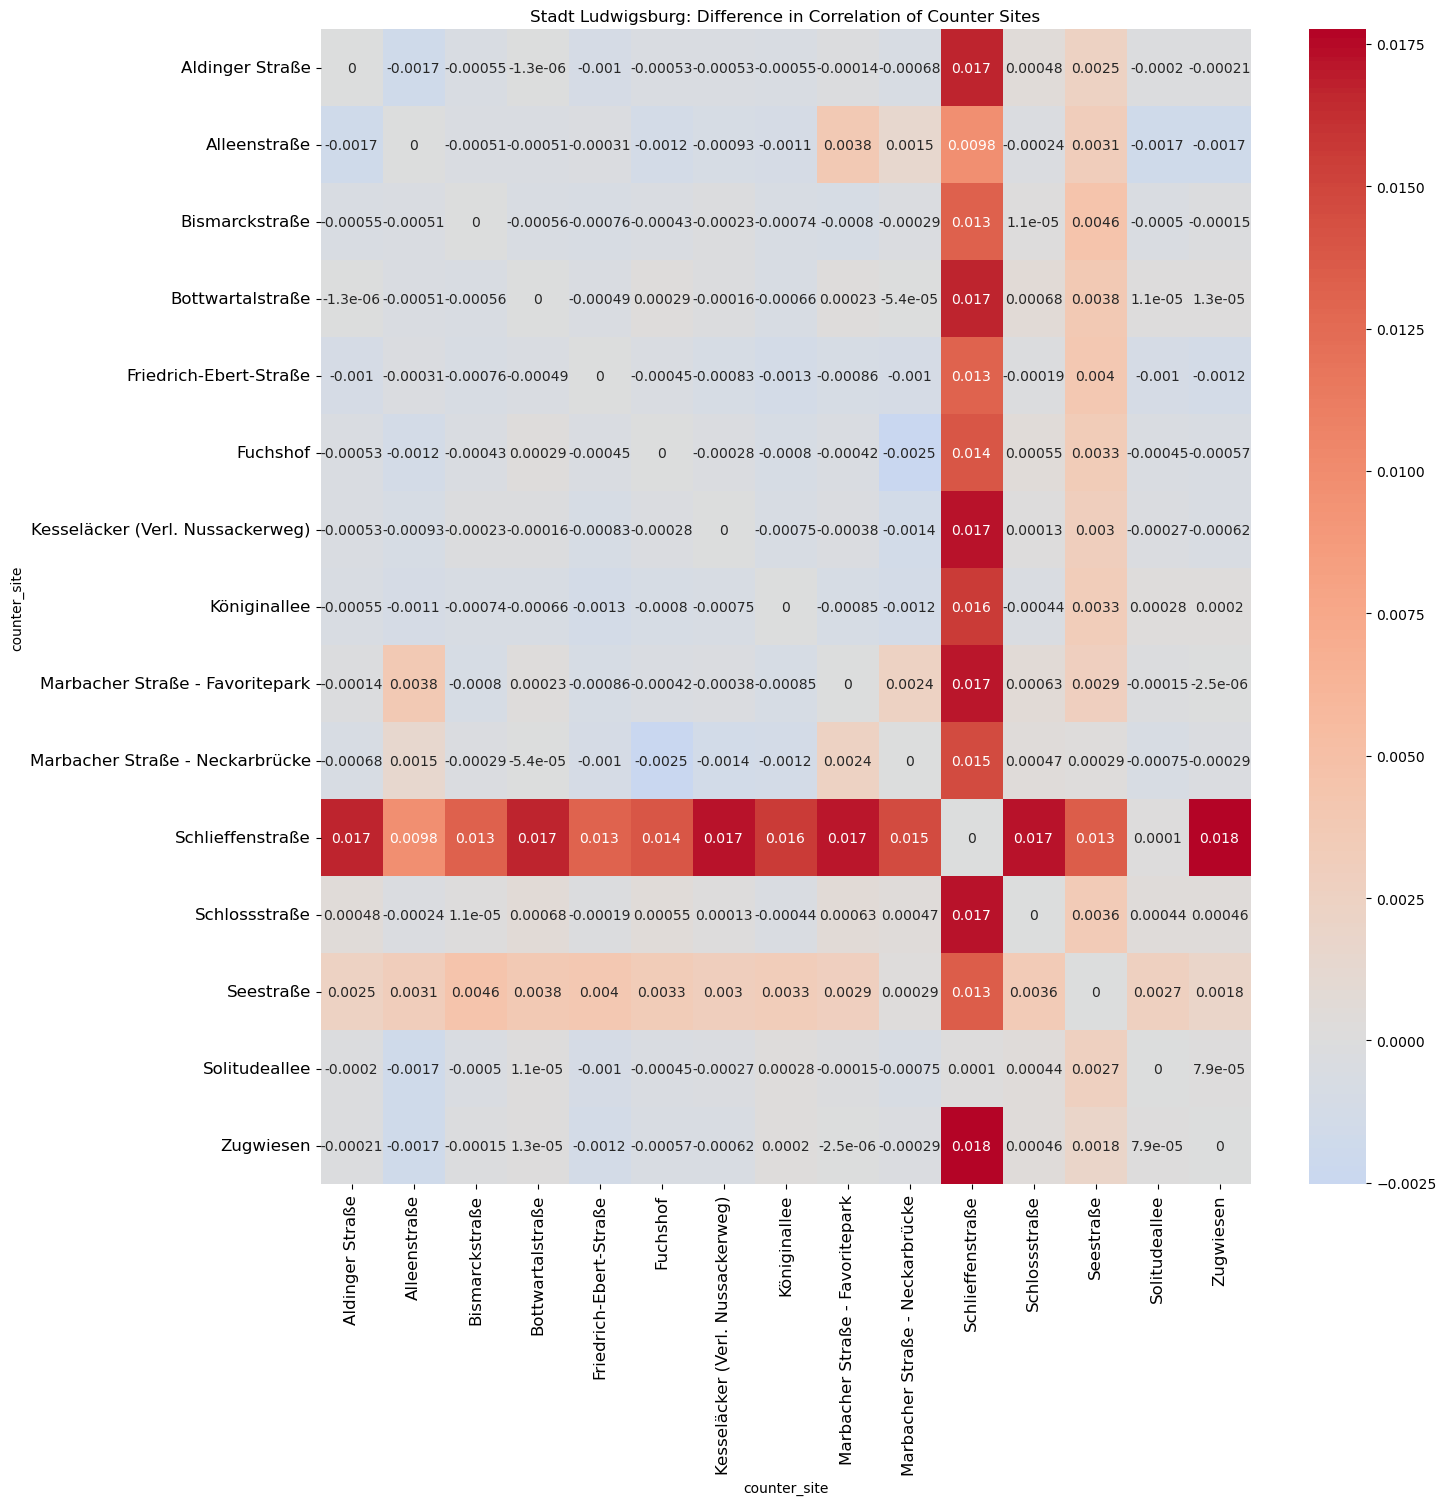

In [12]:
# 3.8 difference between the two correlation matrices
corr_diff_spearman = corr_matrix1_spearman - corr_matrix_spearman
print(abs(corr_diff_spearman).max().max())

plt.figure(figsize=(15, 15))
sns.heatmap(corr_diff_spearman, annot=True, cmap='coolwarm', center=0)
plt.title(f"{title_domain}: Difference in Correlation of Counter Sites")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

#### 4. Visualization

##### 4.1 Distance Measures

Stadt: Stadt Ludwigsburg


C:\Users\Clee\AppData\Local\Temp\ipykernel_728\2410839050.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


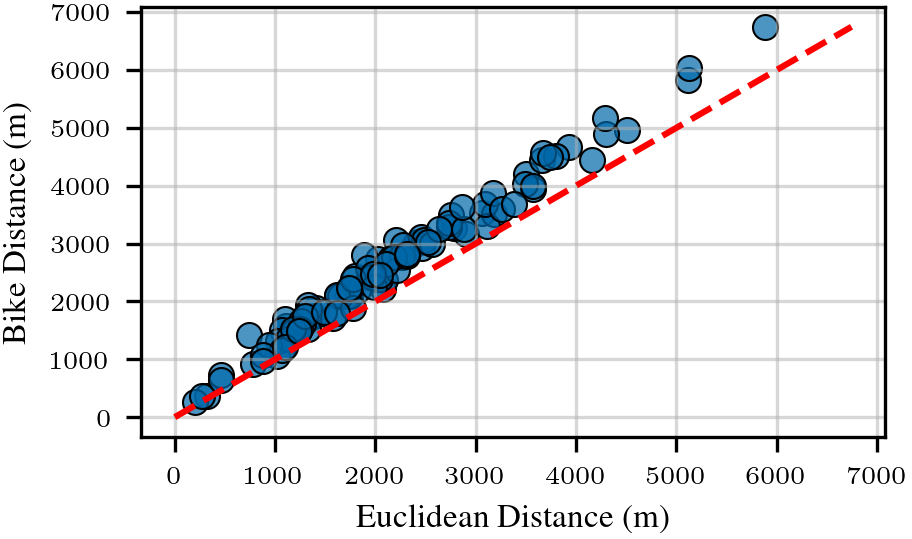

In [13]:
# 4.1.1 check if any bike distances are shorter than euclidean distances (should not be possible)
dist_diff = dist_matrix - dist_matrix_euclid
if (dist_diff < 0).any().any():
    print("Some bike distances are shorter than euclidean distances.")

# 4.1.2 euclidean vs bike distance scatter plot
euclidean_distances = []
bike_distances = []
for site_a in sites1:
    for site_b in sites1:
        if site_a >= site_b:
            continue
        euclidean_distances.append(dist_matrix_euclid.loc[site_a, site_b])
        bike_distances.append(dist_matrix.loc[site_a, site_b])

filename = f"euclidean_vs_bike_distance_{title_domain.replace(' ', '_').lower()}.pdf"
filepath = distcorr_plot_dir / filename

with plt.rc_context(get_style(rel_width =1, font_adjustment=0, display_dpi=300)):
    fig, ax = plt.subplots()
    print("Stadt:",title_domain)
    ax.scatter(euclidean_distances, bike_distances, edgecolors='black', linewidths=0.5)
    max_dist = max(max(euclidean_distances), max(bike_distances))
    plt.plot([0, max_dist], [0, max_dist], color='red', linestyle='--', label='bisector')
    ax.set_xlabel("Euclidean Distance (m)")
    ax.set_ylabel("Bike Distance (m)")
    plt.tight_layout()
    plt.grid(True, alpha=0.5)
    plt.savefig(filepath, dpi=300, bbox_inches="tight")
    plt.show()

The figure compares Euclidean distances with bike distances. The diagonal line (bisector) serves as a visual check: any point below the red line indicates an error, as bike distances should never be shorter than Euclidean distances.  

We can see that the points lie close to the bisector and show little spread, indicating that Euclidean and bike distances do not differ much. This suggests that the stations are well connected.


C:\Users\Clee\AppData\Local\Temp\ipykernel_728\51999398.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


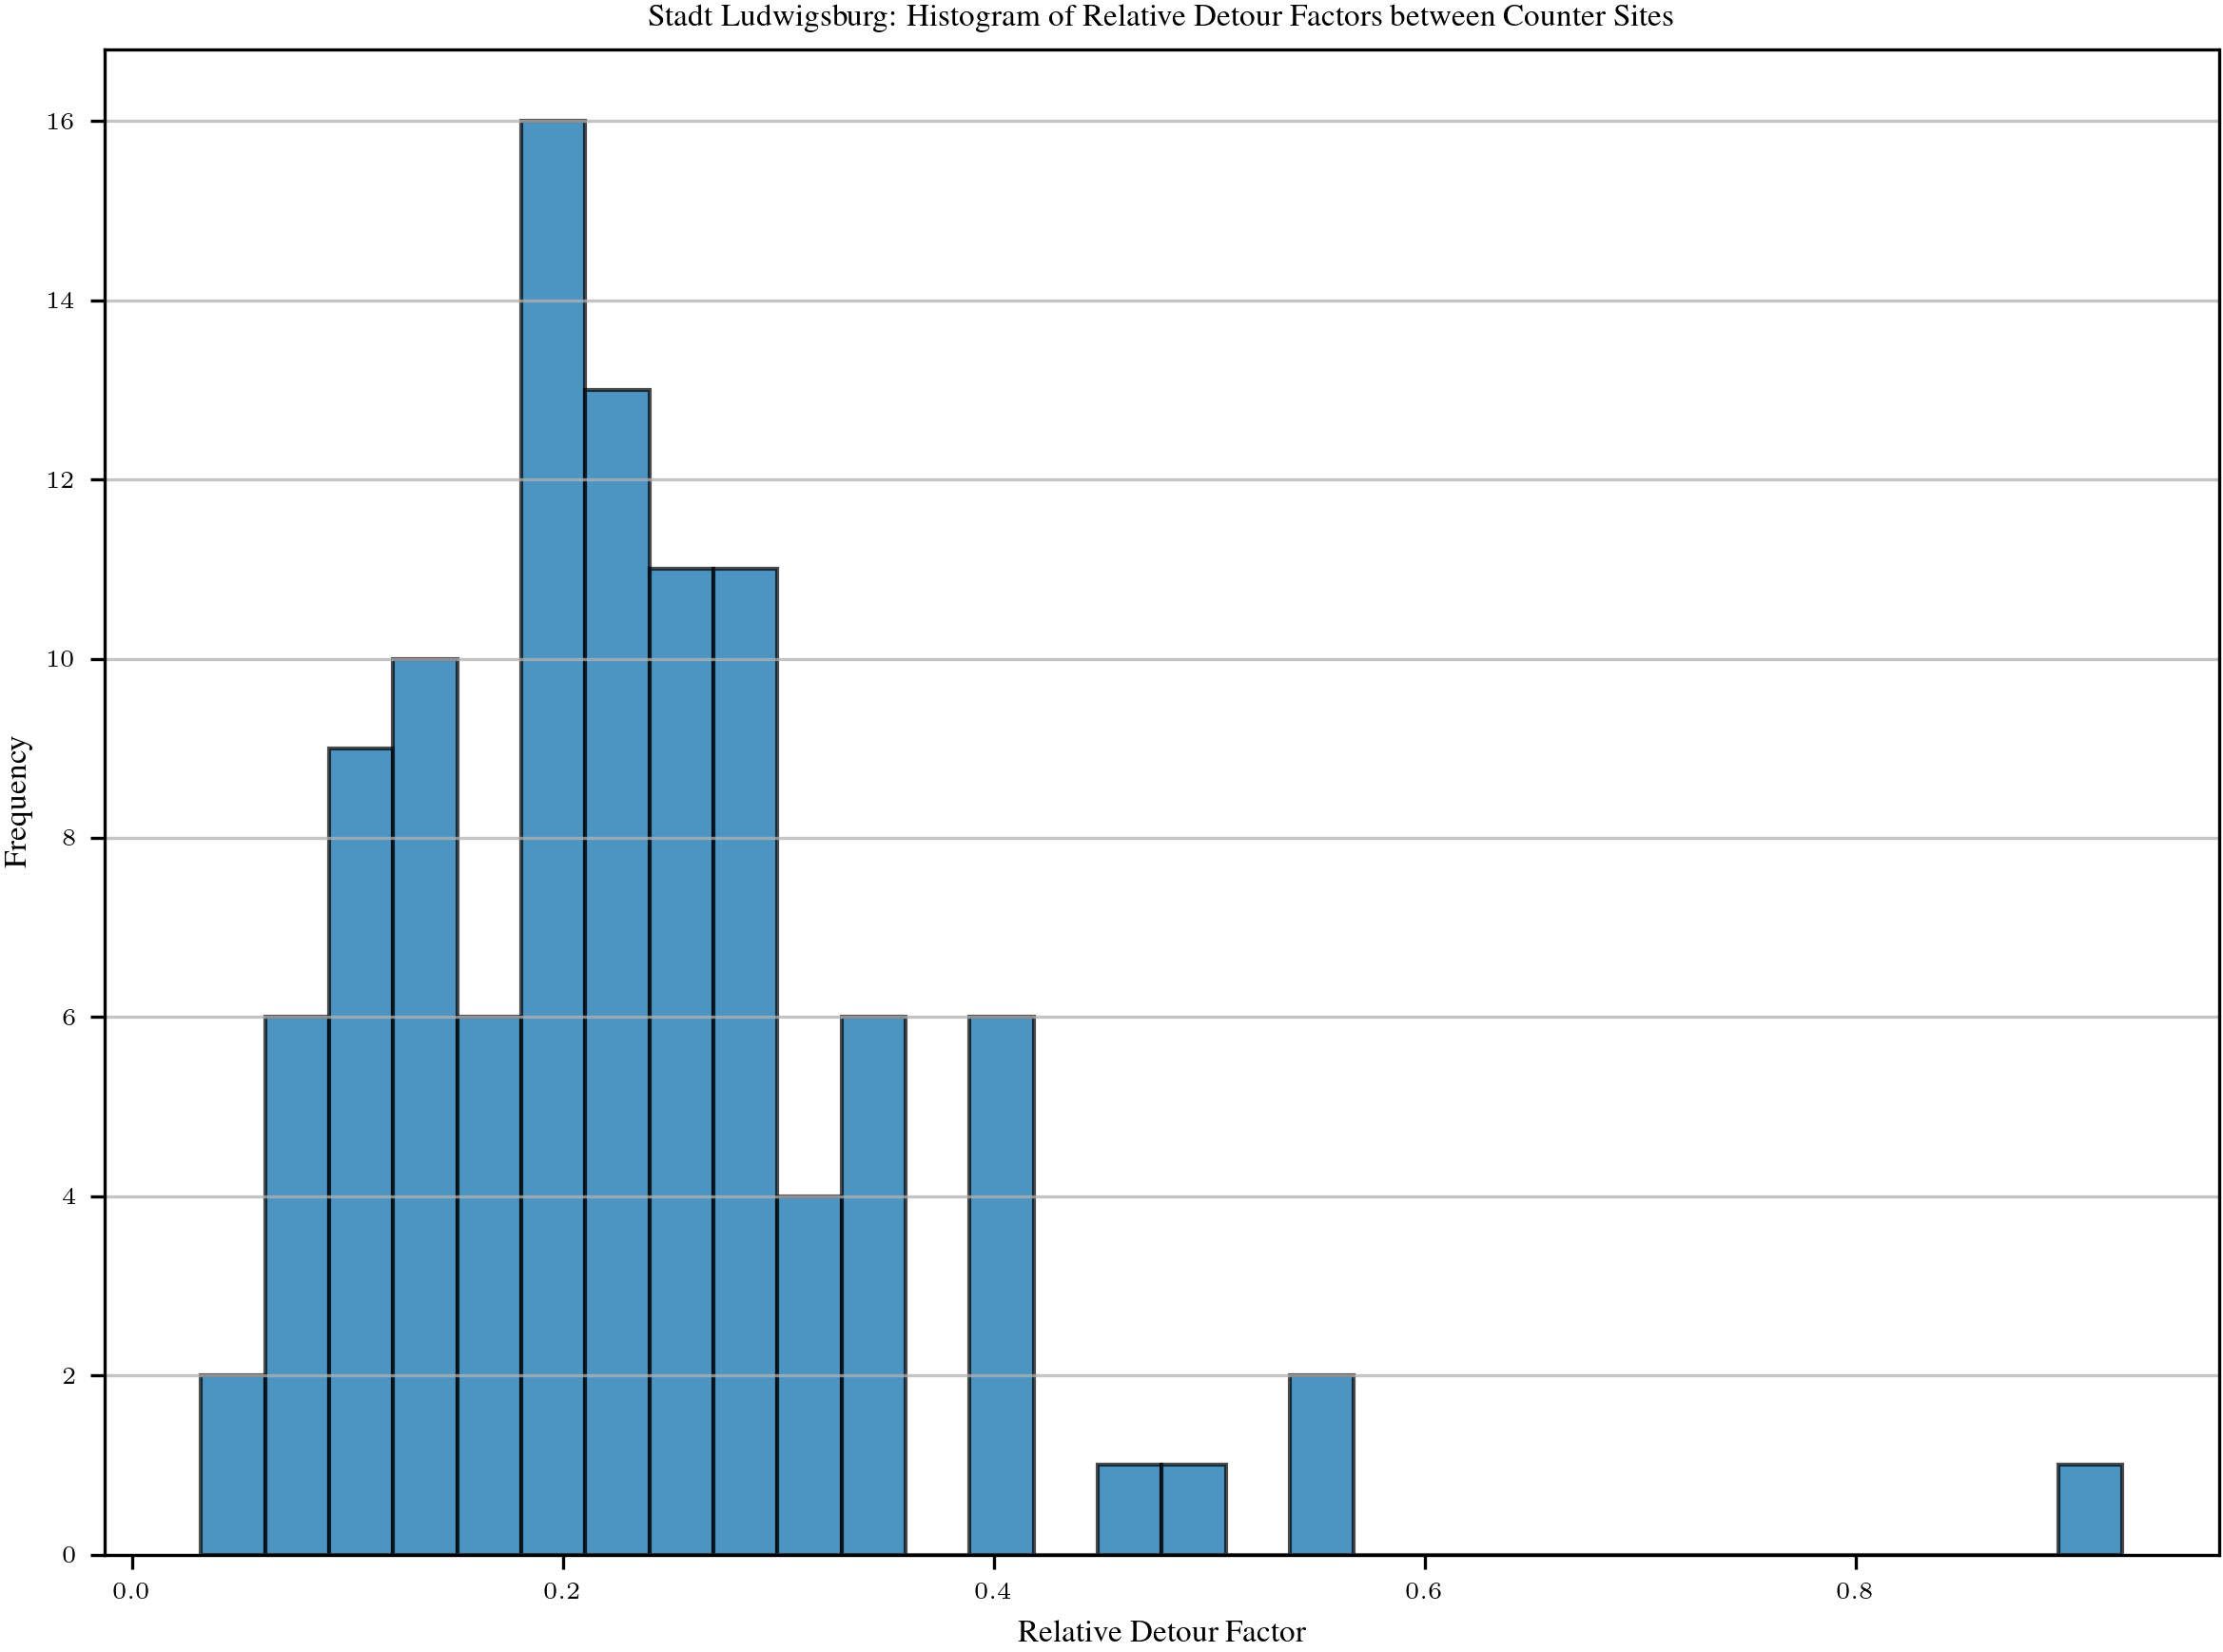

In [14]:
# 4.1.3 detour factor histogram (how much longer is bike distance compared to euclidean distance)
filename = f"detour_factor_histogram_{title_domain.replace(' ', '_').lower()}.pdf"
filepath = distcorr_plot_dir / filename

detour_factors = []
for i in range(len(sites1)):
    for j in range(i + 1, len(sites1)):
        site1 = sites1[i]
        site2 = sites1[j]
        bike_dist = dist_matrix.loc[site1, site2]
        euclid_dist = dist_matrix_euclid.loc[site1, site2]
        if euclid_dist > 0:
            detour_factor = (bike_dist - euclid_dist) / euclid_dist
            detour_factors.append(detour_factor)

safe_title = title_domain.replace("&", r"\&")
with plt.rc_context(get_style(rel_width=1, font_adjustment=0, display_dpi=300)):
    plt.figure(figsize=(8, 6))
    plt.hist(detour_factors, bins=30, edgecolor='black', alpha=0.7)
    plt.xlabel("Relative Detour Factor")
    plt.ylabel("Frequency")
    plt.title(f"{safe_title}: Histogram of Relative Detour Factors between Counter Sites")
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.savefig(filepath, dpi=300, bbox_inches="tight")
    plt.show()


##### 4.2 Distance and Correlation

In this step, we examine how correlation varies with distance.   
Almost all sites show negative Spearman (except Ravensburg)

Ludwigsburg provides a clear example of this trend: sites that are further apart show significantly weaker correlations.

Stadt: Stadt Ludwigsburg


C:\Users\Clee\AppData\Local\Temp\ipykernel_728\736614802.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


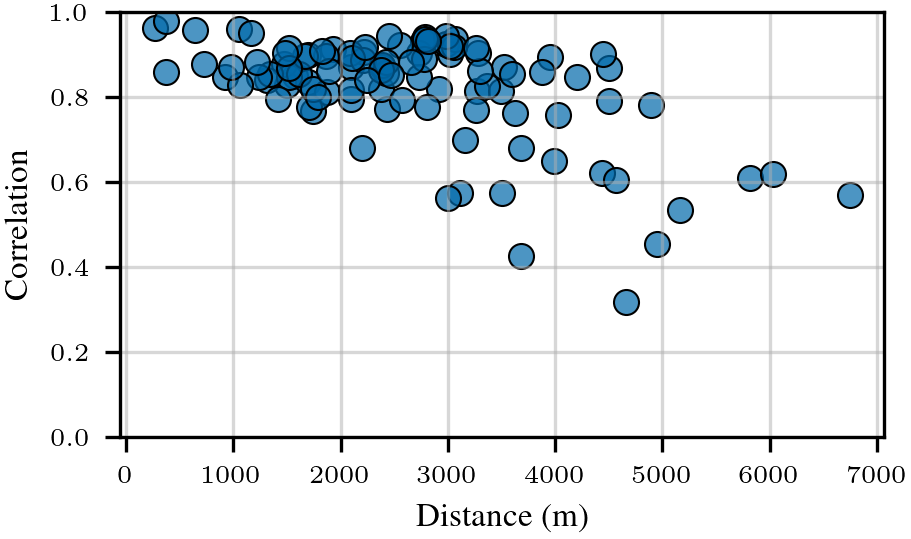

In [23]:
# 4.2.1 bike distance vs correlation plot
correlations = []
distance_values = []
for i in range(len(sites1)):
    for j in range(i + 1, len(sites1)):
        site1 = sites1[i]
        site2 = sites1[j]
        distance = dist_matrix.loc[site1, site2]
        correlation = corr_matrix1.loc[site1, site2]
        distance_values.append(distance)
        correlations.append(correlation)

filename = f"bike_distance_vs_correlation_{title_domain.replace(' ', '_').lower()}.pdf"
filepath = distcorr_plot_dir / filename

with plt.rc_context(get_style(rel_width =1, font_adjustment=0, display_dpi=300)):
    fig, ax = plt.subplots()
    print("Stadt:",title_domain)
    ax.scatter(distance_values, correlations, edgecolors='black', linewidths=0.5)
    ax.set_xlabel("Distance (m)")
    ax.set_ylabel("Correlation")
    ax.set_ylim(0, 1)
    plt.tight_layout()
    plt.grid(True, alpha=0.5)
    plt.savefig(filepath, dpi=300, bbox_inches="tight")
    plt.show()

Stadt: Stadt Ludwigsburg


C:\Users\Clee\AppData\Local\Temp\ipykernel_728\3996812102.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


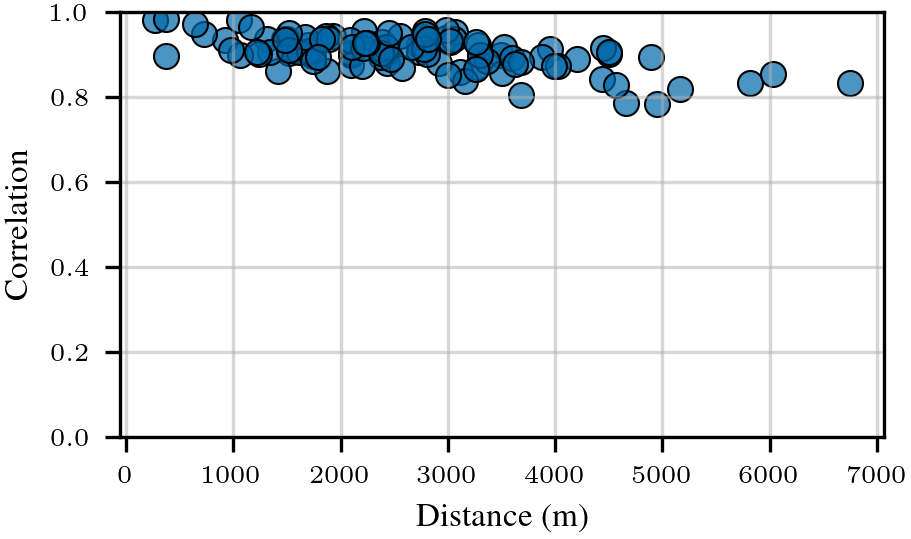

In [24]:
# 4.2.1 bike distance vs correlation plot Spearman
correlations = []
distance_values = []
for i in range(len(sites1)):
    for j in range(i + 1, len(sites1)):
        site1 = sites1[i]
        site2 = sites1[j]
        distance = dist_matrix.loc[site1, site2]
        correlation = corr_matrix1_spearman.loc[site1, site2]
        distance_values.append(distance)
        correlations.append(correlation)

filename = f"bike_distance_vs_correlation_{title_domain.replace(' ', '_').lower()}.pdf"
filepath = distcorr_plot_dir / filename

with plt.rc_context(get_style(rel_width =1, font_adjustment=0, display_dpi=300)):
    fig, ax = plt.subplots()
    print("Stadt:",title_domain)
    ax.scatter(distance_values, correlations, edgecolors='black', linewidths=0.5)
    ax.set_xlabel("Distance (m)")
    ax.set_ylabel("Correlation")
    ax.set_ylim(0, 1)
    plt.tight_layout()
    plt.grid(True, alpha=0.5)
    plt.savefig(filepath, dpi=300, bbox_inches="tight")
    plt.show()

In [19]:
# spearman correlation between bike distance and correlation
from scipy.stats import spearmanr
corr_coef, p_value = spearmanr(distance_values, correlations)
print(f"Spearman correlation coefficient between bike distance and correlation: {corr_coef:.4f} (p-value: {p_value:.4f})")

Spearman correlation coefficient between bike distance and correlation: -0.5055 (p-value: 0.0000)


Stadt: Stadt Ludwigsburg


C:\Users\Clee\AppData\Local\Temp\ipykernel_728\1538487918.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


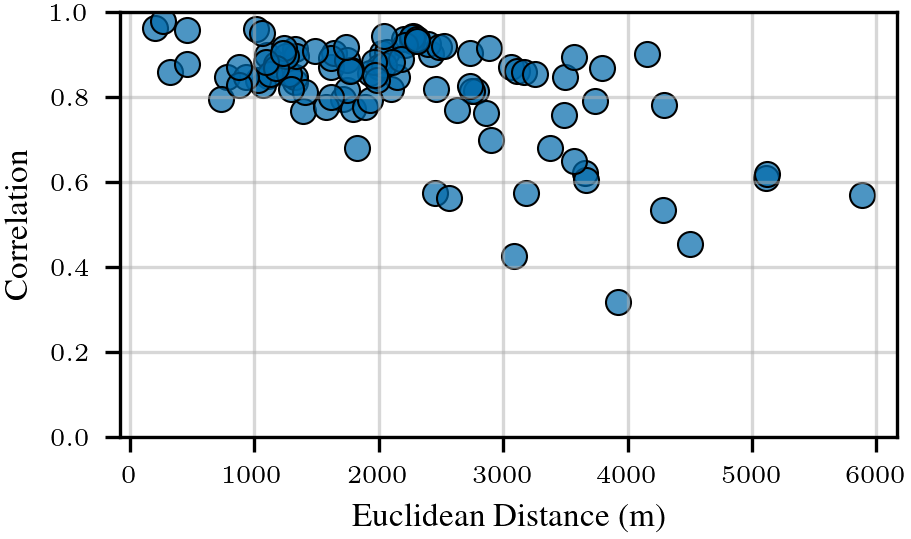

In [26]:
# 4.2.2 euclidean distance vs correlation plot
correlations = []
distance_values = []
for i in range(len(sites1)):
    for j in range(i + 1, len(sites1)):
        site1 = sites1[i]
        site2 = sites1[j]
        distance = dist_matrix_euclid.loc[site1, site2]
        correlation = corr_matrix1.loc[site1, site2]
        distance_values.append(distance)
        correlations.append(correlation)


filename = f"euclidean_distance_vs_correlation_{title_domain.replace(' ', '_').lower()}.pdf"
filepath = distcorr_plot_dir / filename

with plt.rc_context(get_style(rel_width =1, font_adjustment=0, display_dpi=300)):
    fig, ax = plt.subplots()
    print("Stadt:",title_domain)
    ax.scatter(distance_values, correlations, edgecolors='black', linewidths=0.5)
    ax.set_xlabel("Euclidean Distance (m)")
    ax.set_ylabel("Correlation")
    ax.set_ylim(0, 1)
    plt.tight_layout()
    plt.grid(True, alpha=0.5)
    plt.savefig(filepath, dpi=300, bbox_inches="tight")
    plt.show()

Stadt: Stadt Ludwigsburg


C:\Users\Clee\AppData\Local\Temp\ipykernel_728\1746626345.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


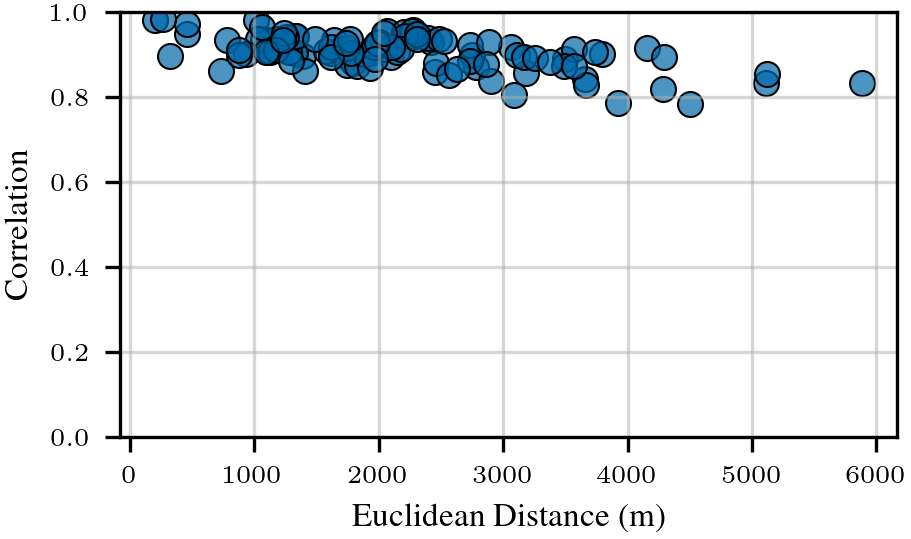

In [25]:
# 4.2.2 euclidean distance vs correlation plot Spearman
correlations = []
distance_values = []
for i in range(len(sites1)):
    for j in range(i + 1, len(sites1)):
        site1 = sites1[i]
        site2 = sites1[j]
        distance = dist_matrix_euclid.loc[site1, site2]
        correlation = corr_matrix1_spearman.loc[site1, site2]
        distance_values.append(distance)
        correlations.append(correlation)


filename = f"euclidean_distance_vs_correlation_{title_domain.replace(' ', '_').lower()}.pdf"
filepath = distcorr_plot_dir / filename

with plt.rc_context(get_style(rel_width =1, font_adjustment=0, display_dpi=300)):
    fig, ax = plt.subplots()
    print("Stadt:",title_domain)
    ax.scatter(distance_values, correlations, edgecolors='black', linewidths=0.5)
    ax.set_xlabel("Euclidean Distance (m)")
    ax.set_ylabel("Correlation")
    ax.set_ylim(0, 1)
    plt.tight_layout()
    plt.grid(True, alpha=0.5)
    plt.savefig(filepath, dpi=300, bbox_inches="tight")
    plt.show()

In [27]:
from tabulate import tabulate

# 5. summary statistics table
def upper_tri_values(df):
    values = []
    sites = df.index
    for i in range(len(sites)):
        for j in range(i + 1, len(sites)):
            values.append(df.iloc[i, j])
    return np.array(values)

euclid_vals = upper_tri_values(dist_matrix_euclid)
bike_vals = upper_tri_values(dist_matrix)
diff_vals = upper_tri_values(diff_matrix)
corr_vals = upper_tri_values(corr_matrix1)
snap_vals = np.array(list(counter_to_node_dist.values()))
rel_detour_vals = np.array(detour_factors)


def summarize(values):
    return {
        'Mean': np.mean(values),
        'Median': np.median(values),
        'Std': np.std(values),
        'Min': np.min(values),
        '25%': np.percentile(values, 25),
        '75%': np.percentile(values, 75),
        'Max': np.max(values)
    }

n_pairs = len(euclid_vals)
n_stations = len(sites1)

meta_table = pd.DataFrame({
    "Value": [n_total, n_aligned, n_aligned / n_total, n_pairs, n_stations]
}, index=[
    "Total timestamps",
    "Aligned timestamps",
    "Share aligned",
    "Number of site pairs",
    "Number of stations"
])
meta_table.loc["Spearman ρ (Bike Distance vs Correlation)"] = f"{corr_coef:.3f} (p={p_value:.4f})"


summary_table = pd.DataFrame({
    'Euclid Distance (m)': summarize(euclid_vals),
    'Bike Distance (m)': summarize(bike_vals),
    'Difference (m)': summarize(diff_vals),
    'Snap Distance (m)': summarize(snap_vals),
    'Correlation': summarize(corr_vals),
    'Relative Detour': summarize(rel_detour_vals)
})

filename = TABLES_DIR / f"summary_statistics_{title_domain.replace(' ', '_').lower()}.md"
with open(filename, "w", encoding="utf-8") as f:
    f.write(f"# Summary Statistics – {title_domain}\n\n")

    f.write("## Data Coverage\n\n")
    f.write(meta_table.to_markdown())
    f.write("\n\n")

    f.write("## Pairwise Statistics (Upper Triangle)\n\n")
    f.write(summary_table.to_markdown())
    f.write("\n")
filepath = TABLES_DIR / filename

print(meta_table)
print(summary_table)

                                                       Value
Total timestamps                                     70852.0
Aligned timestamps                                   39386.0
Share aligned                                       0.555891
Number of site pairs                                   105.0
Number of stations                                      15.0
Spearman ρ (Bike Distance vs Correlation)  -0.505 (p=0.0000)
        Euclid Distance (m)  Bike Distance (m)  Difference (m)  \
Mean            2184.844487        2637.788574      452.944088   
Median          2025.898003        2453.067300      458.452029   
Std             1110.705505        1247.813988      213.169111   
Min              205.961083         267.293556       32.674393   
25%             1327.372094        1708.927671      300.274900   
75%             2786.444776        3285.307864      599.692682   
Max             5880.954814        6744.260413      918.882975   

        Snap Distance (m)  Correlation  Rela